# Ambient Temperature System Failure

In [1]:
# general imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from utils import plot, plot_ts, plot_rws, plot_error, unroll_ts

## Part 1

### Data Loading
There is a collection of data already available in Orion, to load them, we use the `load_signal` function and pass the name of the signal we wish to obtain. Similarly, since this data is labeled, we use the `load_anomalies` function to get the corresponding anomaly of the signal

In [2]:
from orion.data import load_signal, load_anomalies

In [3]:
signal = 'ambient_temperature_system_failure'

# load signal
df = load_signal(signal)

# load ground truth anomalies
known_anomalies = load_anomalies(signal)

df.head(5)

,timestamp,value
0,1372888800,69.880835
1,1372892400,71.220227
2,1372896000,70.877805
3,1372899600,68.959400
4,1372903200,69.283551


C:\Users\Raunak\Downloads\Orion-master\Orion-master\notebooks\tulog\utils.py:145: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


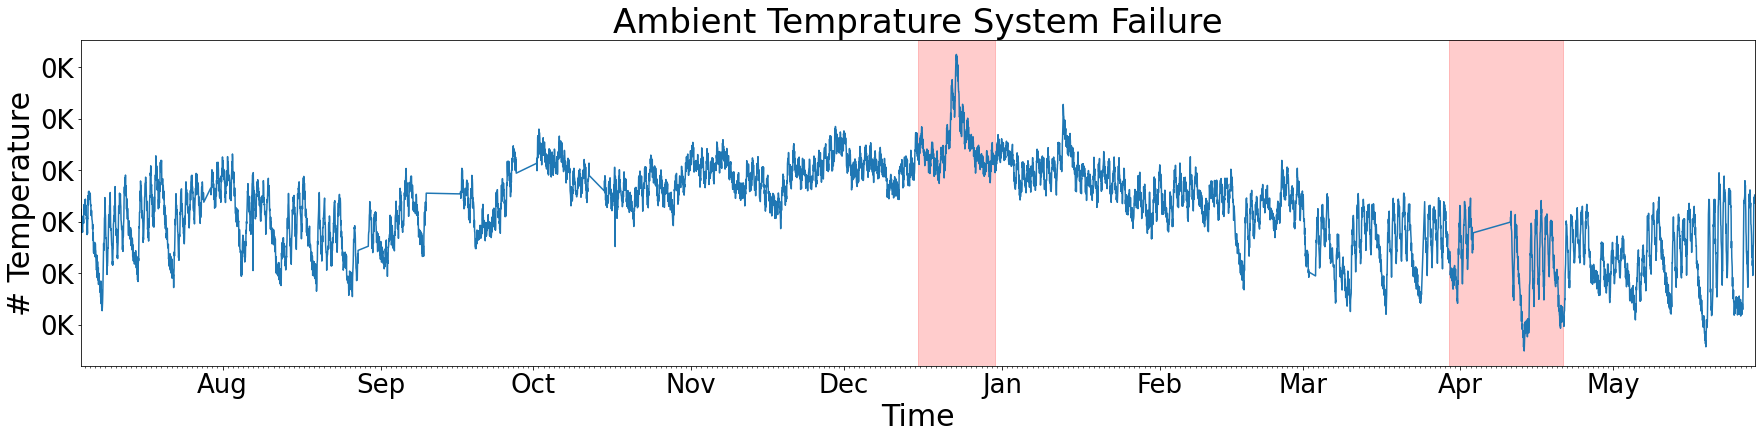

In [4]:
plot(df, known_anomalies)

---

## Part 2
 Training the GAN MODEL to create new minority data

### Orion API
 
TadGAN is accustomed with the Orion API. The Orion API basically helps us to interact with Anomaly Detection pipeline of TadGAN 

In [ ]:
from orion import Orion


orion = Orion(
    pipeline='tadgan.json'
)

anomalies = orion.fit_detect(df) # fitdetect function helps to train the model and detect the anomaly. Inbuilt with Orion

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


C:\Users\Raunak\.conda\envs\orion\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



C:\Users\Raunak\.conda\envs\orion\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Raunak\.conda\envs\orion\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Raunak\.conda\envs\orion\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 1/35, [Dx loss: [-0.257303   -1.7417881   0.86701065  0.06174739]] [Dz loss: [-1.6683345  -1.0857497  -1.5349134   0.09523289]] [G loss: [ 1.9634862  -0.84619313  2.2603967   0.05492823]]
Epoch: 2/35, [Dx loss: [-0.9617868  -2.600803    1.383023    0.02559931]] [Dz loss: [-2.6387079  -1.7990074  -1.515181    0.06754817]] [G loss: [ 0.9685436  -1.3319018   1.9192735   0.03811719]]


### Visualizing the results.

C:\Users\Raunak\Downloads\Orion-master\Orion-master\notebooks\tulog\utils.py:145: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


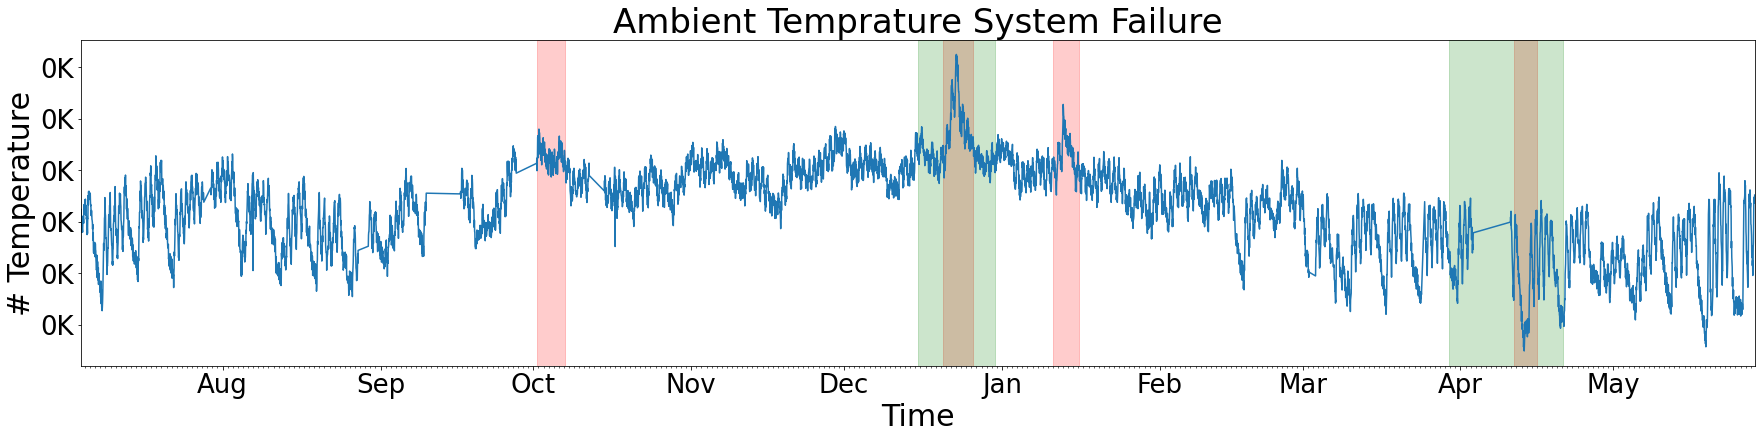

,start,end,severity
0,1380636000,1381104000,0.441137
1,1387506600,1388023200,0.467463
2,1389378600,1389817800,0.392278
3,1397205000,1397586600,0.219161


In [6]:
plot(df, [anomalies, known_anomalies])
anomalies.head(5)

The red intervals depict the detected anomalies, the green intervals show the ground truth. 
As shown above, the model was able to detect 2 out of 4 anomalies. 
The ones which don't have the green are the ones that weren't actually anomalies but they are falling out of shape with respect to the remaining signal hence our model depicted them.

If we were to look at the `tadgan.json` model, we find these already defined sequential primitives, the use of which is defined below in the notebook:

```
"primitives": [ 
    "mlprimitives.custom.timeseries_preprocessing.time_segments_aggregate”,
    "sklearn.impute.SimpleImputer",
    "sklearn.preprocessing.MinMaxScaler",
    "mlprimitives.custom.timeseries_preprocessing.rolling_window_sequences",
    "orion.primitives.tadgan.TadGAN",
    "orion.primitives.tadgan.score_anomalies",
    "orion.primitives.timeseries_anomalies.find_anomalies"
]
```

### Data Preparation 
#### A. Data frequency

- interval: an interger that refers to the time span to compute aggregation of.
- method: what aggregation method should be used to compute the value, by default this set to the mean.

Our first dataset is equally spaced or every datapoint is recorded after a set time so this step can be skipped for this dataset.

In [7]:
def time_segments_aggregate(X, interval, time_column, method=['mean']):
    """Aggregate values over given time span.
    Args:
        X (ndarray or pandas.DataFrame):
            N-dimensional sequence of values.
        interval (int):
            Integer denoting time span to compute aggregation of.
        time_column (int):
            Column of X that contains time values.
        method (str or list):
            Optional. String describing aggregation method or list of strings describing multiple
            aggregation methods. If not given, `mean` is used.
    Returns:
        ndarray, ndarray:
            * Sequence of aggregated values, one column for each aggregation method.
            * Sequence of index values (first index of each aggregated segment).
    """
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    X = X.sort_values(time_column).set_index(time_column)

    if isinstance(method, str):
        method = [method]

    start_ts = X.index.values[0]
    max_ts = X.index.values[-1]

    values = list()
    index = list()
    while start_ts <= max_ts:
        end_ts = start_ts + interval
        subset = X.loc[start_ts:end_ts - 1]
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method
        ]
        values.append(np.concatenate(aggregated))
        index.append(start_ts)
        start_ts = end_ts

    return np.asarray(values), np.asarray(index)

X, index = time_segments_aggregate(df, interval=1800, time_column='timestamp')

#### B. Data imputation

impute missing values that appear within the signal using scikit-learn's `SimpleImputer` which fills missing values by the mean value.

In [8]:
imp = SimpleImputer()
X = imp.fit_transform(X)

#### C. data normalization 
Normalize the data between a specific range, we use scikit-learn's `MinMaxScaler` to scale data between [-1, 1].

In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

#### Plotting the changed the y-axis changed after normalizing the data between [-1, 1]

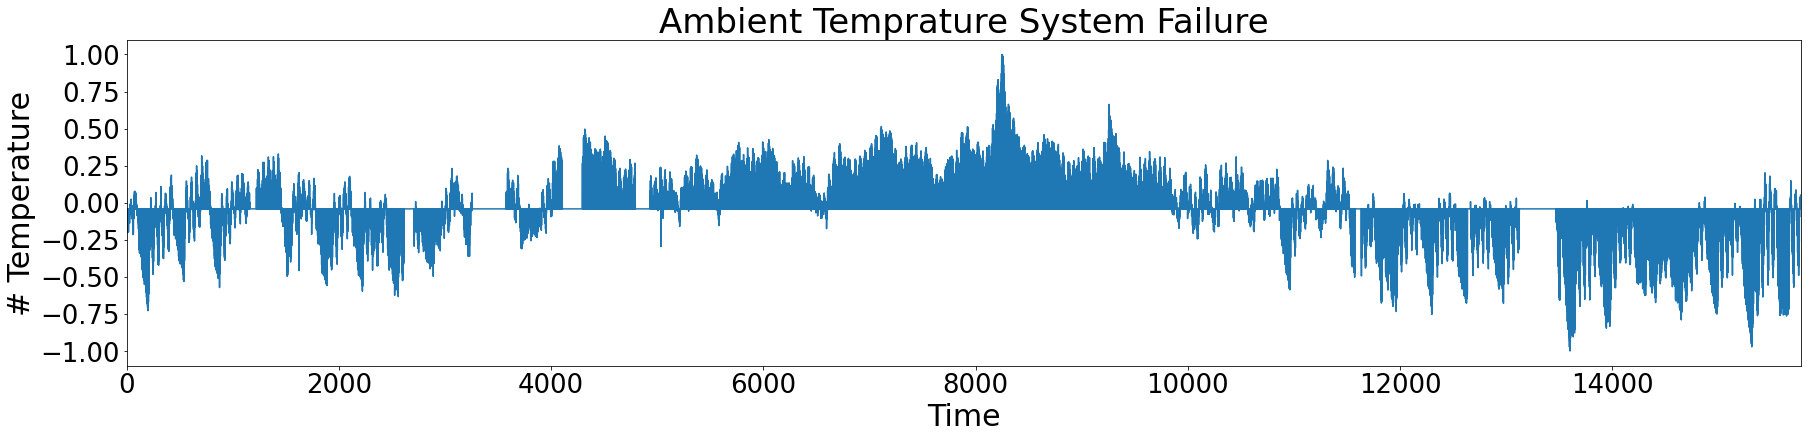

In [10]:
plot_ts(X)

#### D. Slice the data in form of small Windows
The model can omly take in certain training examples which are nothing but snapshots of signal at different times. Here we generate those small windows of a particular width and size using which the model is then trained.

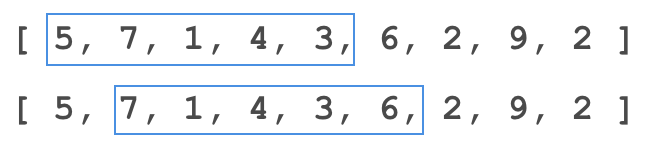

In [11]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    """Create rolling window sequences out of time series data.
    The function creates an array of input sequences and an array of target sequences by rolling
    over the input sequence with a specified window.
    Optionally, certain values can be dropped from the sequences.
    Args:
        X (ndarray):
            N-dimensional sequence to iterate over.
        index (ndarray):
            Array containing the index values of X.
        window_size (int):
            Length of the input sequences.
        target_size (int):
            Length of the target sequences.
        step_size (int):
            Indicating the number of steps to move the window forward each round.
        target_column (int):
            Indicating which column of X is the target.
        drop (ndarray or None or str or float or bool):
            Optional. Array of boolean values indicating which values of X are invalid, or value
            indicating which value should be dropped. If not given, `None` is used.
        drop_windows (bool):
            Optional. Indicates whether the dropping functionality should be enabled. If not
            given, `False` is used.
    Returns:
        ndarray, ndarray, ndarray, ndarray:
            * input sequences.
            * target sequences.
            * first index value of each input sequence.
            * first index value of each target sequence.
    """
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)

X, y, X_index, y_index = rolling_window_sequences(X, index, 
                                                  window_size=100, 
                                                  target_size=1, 
                                                  step_size=1,
                                                  target_column=0)

In [12]:
print("Training data input shape: {}".format(X.shape))  #total input size, window size and target size(anomaly or normal)
print("Training data index shape: {}".format(X_index.shape))
print("Training y shape: {}".format(y.shape))
print("Training y index shape: {}".format(y_index.shape))

Training data input shape: (15675, 100, 1)
Training data index shape: (15675,)
Training y shape: (15675, 1)
Training y index shape: (15675,)


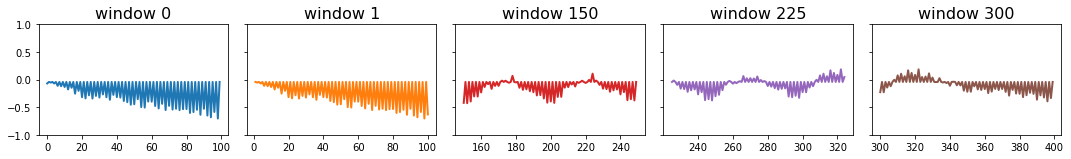

In [13]:
plot_rws(X)

**X** represents the input used to train the model, here `X` has `15675` training data points.
Notice that **100** represents the window size. 
On the other hand, **y** is the real signal after processing, which we will use later on to calculate the error between the reconstructed and real signal. 


### Pipeline Training and Detection

To use the `TadGAN` model, we specify a number of parameters including the model layers, input dimensions, the number of epochs, the learning rate, etc. 

In [14]:
from model import hyperparameters
from orion.primitives.tadgan import TadGAN

hyperparameters["epochs"] = 10
hyperparameters["shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64

tgan = TadGAN(**hyperparameters)
tgan.fit(X)

C:\Users\Raunak\.conda\envs\orion\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Raunak\.conda\envs\orion\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Raunak\.conda\envs\orion\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Raunak\.conda\envs\orion\lib\site-packages\keras\engine\training.py:297: UserWarning:

Epoch: 1/10, [Dx loss: [-0.2991795  -1.592781    0.7554231   0.05381782]] [Dz loss: [-1.7939639  -1.7599437  -0.93104774  0.0897027 ]] [G loss: [ 1.2776332  -0.73162454  1.480734    0.05285242]]
Epoch: 2/10, [Dx loss: [-0.8914597  -2.994462    1.8587478   0.02442535]] [Dz loss: [-2.491267   -2.6437917  -0.40418318  0.05567051]] [G loss: [-0.7838893  -1.8343879   0.6794887   0.03710102]]
Epoch: 3/10, [Dx loss: [-0.820957   -2.8206592   1.7584462   0.02412568]] [Dz loss: [-2.5957632  -2.8047664  -0.27092212  0.04799246]] [G loss: [-0.7739844  -1.688413    0.5672527   0.03471761]]
Epoch: 4/10, [Dx loss: [-0.8737514  -3.153458    2.077799    0.02019081]] [Dz loss: [-2.2731378  -1.5060718  -1.1898875   0.04228218]] [G loss: [-0.13080512 -2.0904553   1.6262479   0.03334024]]
Epoch: 5/10, [Dx loss: [-0.9804205  -4.3526864   3.1903036   0.01819602]] [Dz loss: [-2.798743   -1.091212   -2.555819    0.08482889]] [G loss: [ 0.907264   -3.1936436   3.6859963   0.04149117]]
Epoch: 6/10, [Dx loss: [-

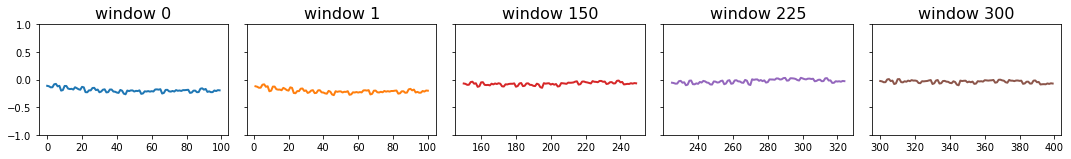

In [15]:
# reconstruct
X_hat, critic = tgan.predict(X)

# visualize X_hat
plot_rws(X_hat)

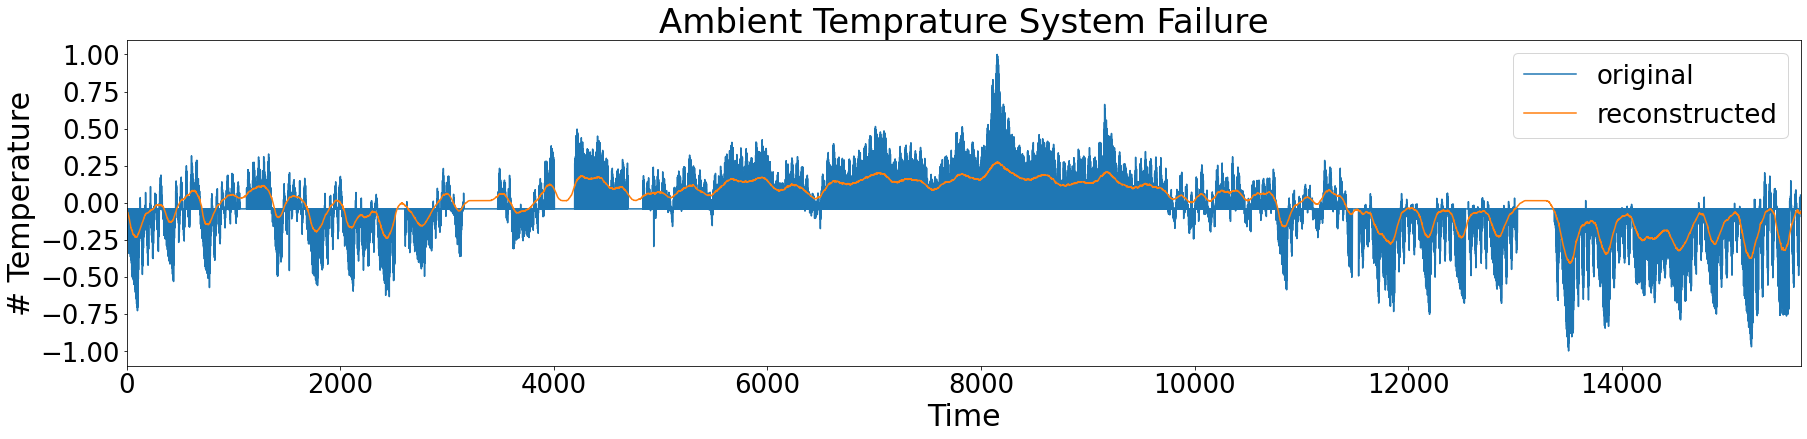

In [16]:
# flatten the predicted windows
y_hat = unroll_ts(X_hat)

# plot the time series
plot_ts([y, y_hat], labels=['original', 'reconstructed'])

We can see that the GAN model did really well in trying to reconstruct the signal. We also see how it expected the signal to be, in comparison to what it actually is. **The discrepancies between the two signals will be used to calculate the error. The higher the error, the more likely it is an anomaly**

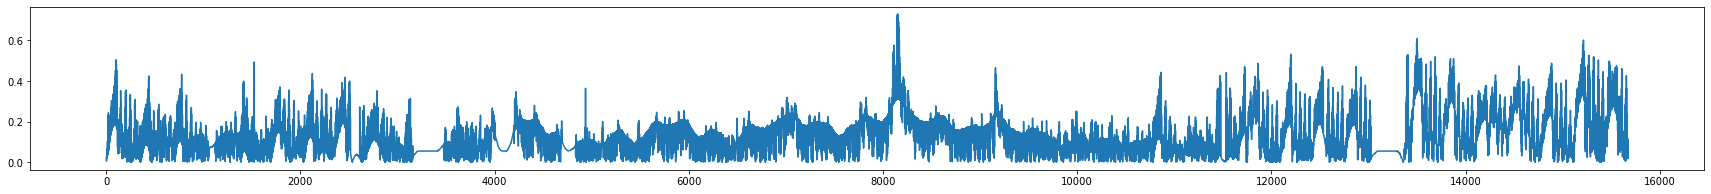

In [17]:
# pair-wise error calculation
error = np.zeros(shape=y.shape)
length = y.shape[0]
for i in range(length):
    error[i] = abs(y_hat[i] - y[i])

# visualize the error curve
fig = plt.figure(figsize=(30, 3))
plt.plot(error)
plt.show()

### Error Computation

In the `TadGAN` pipeline, we use `tadgan.score_anomalies` to perform error calculation for us. It is a smoothed error inbuilt function that uses a window based method to smooth the curve then uses either: area, point difference, or dtw as a measure of discrepancy. 

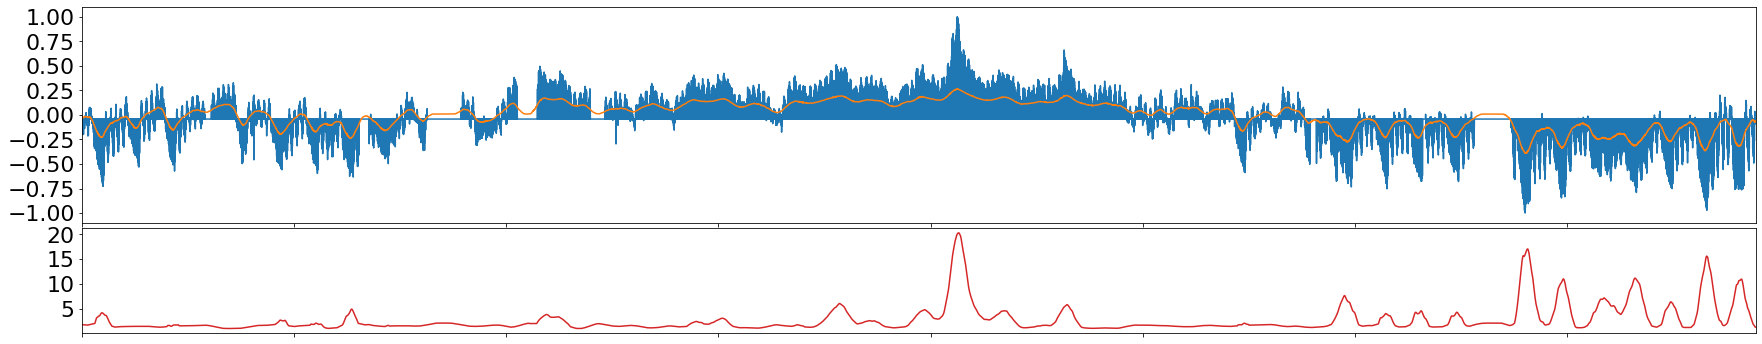

In [18]:
from orion.primitives.tadgan import score_anomalies

error, true_index, true, pred = score_anomalies(X, X_hat, critic, X_index, rec_error_type="dtw", comb="mult")
pred = np.array(pred).mean(axis=2)

# visualize the error curve
plot_error([[true, pred], error])

We have a fixed threshold that is if `error > 10` then let’s classify the datapoint as anomalous. 

In [19]:
# threshold
thresh = 10

intervals = list()

i = 0
max_start = len(error)
while i < max_start:
    j = i
    start = index[i]
    while error[i] > thresh:
        i += 1
    
    end = index[i]
    if start != end:
        intervals.append((start, end, np.mean(error[j: i+1])))
        
    i += 1
        
intervals

[(1387603800, 1387926000, 16.38055571673862),
 (1397280600, 1397514600, 14.50153539920133),
 (1397970000, 1398051000, 10.576993673670499),
 (1399195800, 1399312800, 10.679518201506239),
 (1400356800, 1400551200, 13.078001680430804),
 (1400976000, 1401067800, 10.635677783343379)]

C:\Users\Raunak\Downloads\Orion-master\Orion-master\notebooks\tulog\utils.py:145: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


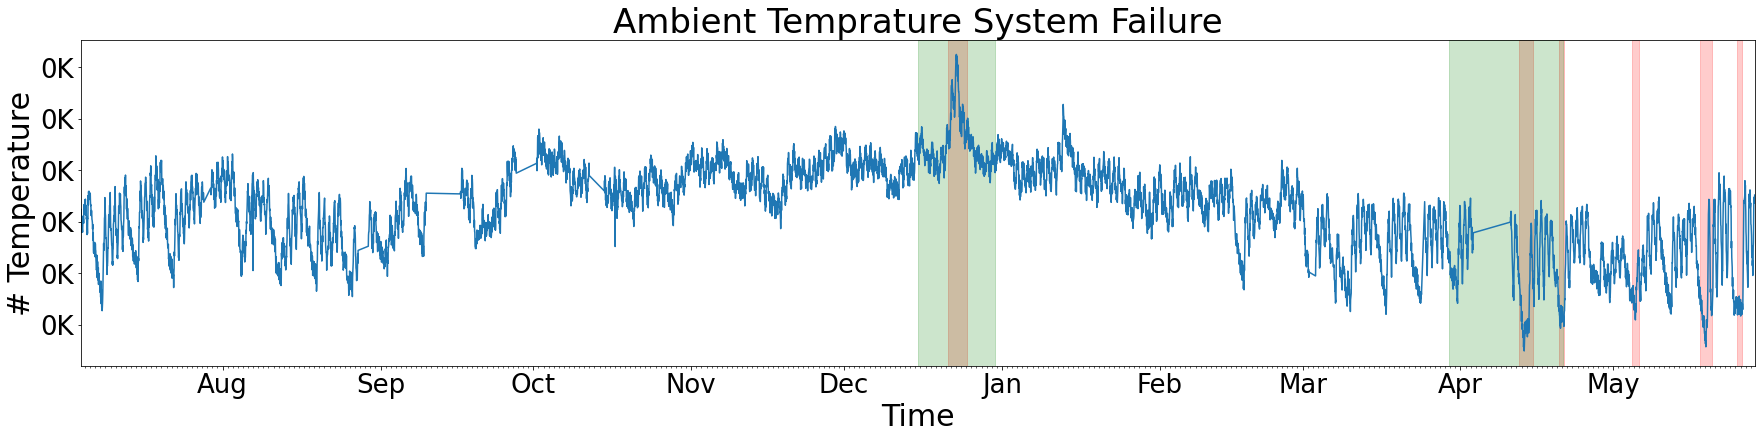

In [20]:
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
plot(df, [anomalies, known_anomalies])

Having a fixed threashold actually couldn't detect all the anomalies so, for each window size we have a varied threshold that will be determined by the mean and standard deviations of that particular window elements

In [21]:
from orion.primitives.timeseries_anomalies import find_anomalies

# find anomalies
intervals = find_anomalies(error, index, 
                           window_size_portion=0.33, 
                           window_step_size_portion=0.1, 
                           fixed_threshold=True)
intervals

array([[1.37733840e+09, 1.37759940e+09, 3.01615047e-01],
       [1.38558240e+09, 1.38591900e+09, 2.56106330e-01],
       [1.38754980e+09, 1.38804480e+09, 9.97484346e-01],
       [1.39721400e+09, 1.39756500e+09, 6.30609267e-01]])

C:\Users\Raunak\Downloads\Orion-master\Orion-master\notebooks\tulog\utils.py:145: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


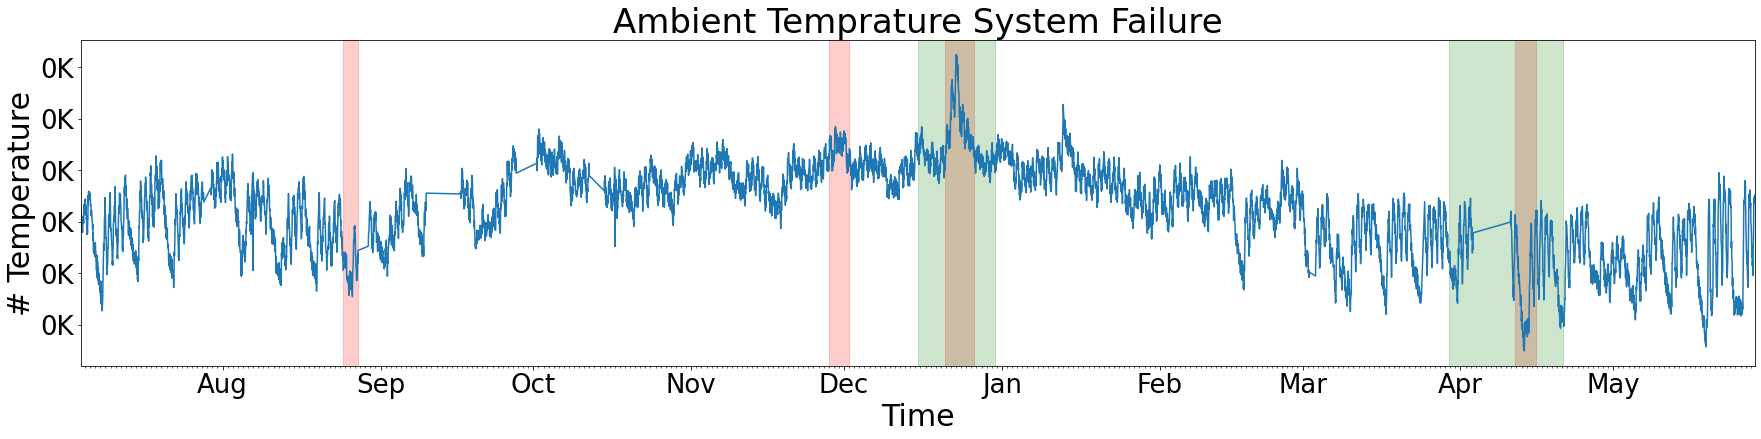

In [22]:
# visualize the result
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
plot(df, [anomalies, known_anomalies])

### End-to-End Pipeline Configuration

In [23]:
from orion import Orion

parameters = {
    "mlprimitives.custom.timeseries_preprocessing.time_segments_aggregate#1": {
            "interval": 3600 # hour level
        },
    'orion.primitives.tadgan.TadGAN#1': {
        'epochs': 25,
        }
}

orion = Orion(
    'tadgan.json',
    parameters
)

anomalies = orion.fit_detect(df)

C:\Users\Raunak\.conda\envs\orion\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Raunak\.conda\envs\orion\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Raunak\.conda\envs\orion\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Raunak\.conda\envs\orion\lib\site-packages\keras\engine\training.py:297: UserWarning:

Epoch: 1/25, [Dx loss: [ 0.7764214  -0.85374767  0.78891236  0.08412567]] [Dz loss: [-1.3342322  -0.80852264 -1.3086332   0.07829239]] [G loss: [ 2.521289   -0.64454395  2.006192    0.11596411]]
Epoch: 2/25, [Dx loss: [-0.6563466  -3.5615885   2.700177    0.02050648]] [Dz loss: [-2.2095249  -1.6057892  -1.1873188   0.05835836]] [G loss: [-0.6472142  -2.7665975   1.4887499   0.06306337]]
Epoch: 3/25, [Dx loss: [-0.02274435  0.37478387 -0.6029155   0.02053876]] [Dz loss: [-2.105716   -2.7830415   0.18669455  0.04906315]] [G loss: [ 1.5856404   0.8230788  -0.01191855  0.077448  ]]
Epoch: 4/25, [Dx loss: [-0.63708484 -4.154663    3.2523828   0.02651959]] [Dz loss: [-2.7346723  -2.3902497  -0.8557245   0.05113008]] [G loss: [-1.795732   -3.2819788   1.0648769   0.04213699]]
Epoch: 5/25, [Dx loss: [-0.39983746  6.4941916  -7.086243    0.01922151]] [Dz loss: [-2.5782313  -3.56087     0.55228436  0.04303542]] [G loss: [ 7.560408    7.617065   -0.40248814  0.03458321]]
Epoch: 6/25, [Dx loss: [-

C:\Users\Raunak\Downloads\Orion-master\Orion-master\notebooks\tulog\utils.py:145: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


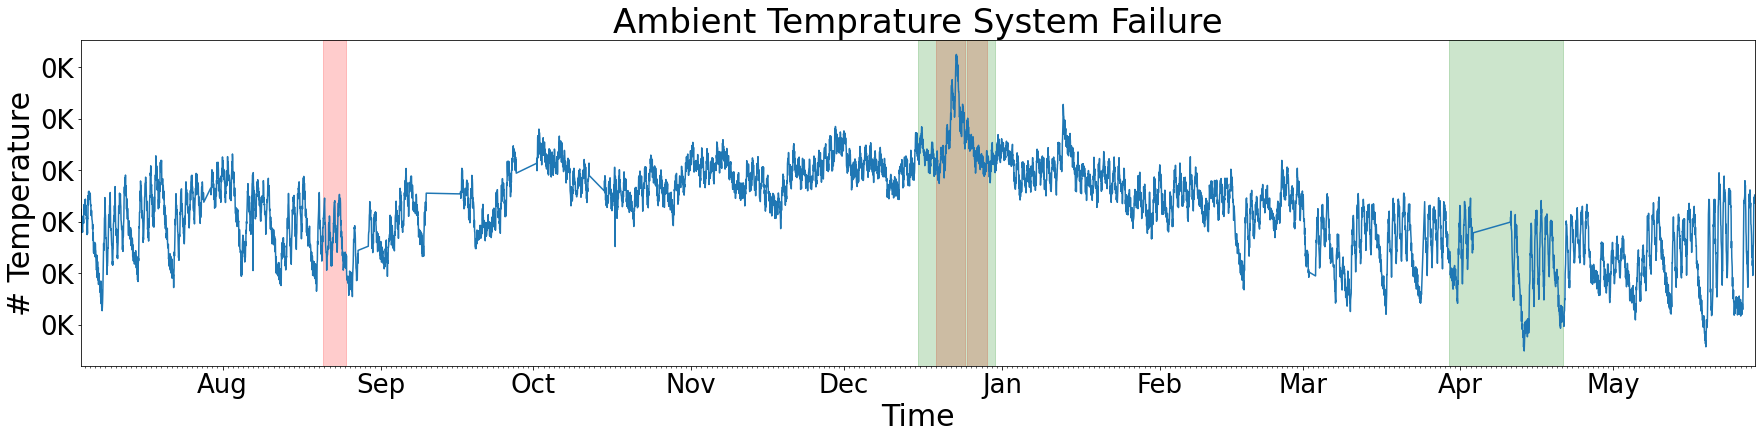

In [24]:
plot(df, [anomalies, known_anomalies])

- `X`: this is the output of the preprocessing steps from averaging, imputing, and scaling. These steps were showcased previously as steps (A, B, and C).
- `X_hat`: this is the "predicted" output by the __TadGAN__ model without any processing. It represents the reconstructed window at each timepoint.
- `es`: this is the error calculated by capturing the discrepancies between original and reconstructed signal.

## Part 3

### Evaluation

We compare the anomalies given to us as ground truth labels to the detected anomalies. But first, we look at some of the mechanisms we have for evaluation, namely:
* **weighted segment**: Assessing every datapoint in the detected anomalies with its counterpart in the ground truth.
    * It first segments the signal into partitions based on the ground truth and detected sequences. 
    * Then it makes a segment to segment comparison and records TP/FP/FN/TN accordingly. 
    * The overall score is weighted by the duration (size) of each segment.
* **overlap segment**: Assesses the detected anomaly segment by seeing if we caught an overlap with the correct anomalies.It is a more lenient approach of evaluation. It takes the perspective of rewarding the system if it manages to alarm the user of a subset of an anomaly. More particularly, it records:

    1) TP, if a ground truth segment overlaps with the detected segment. 

    2) FN, If the ground truth segment does not overlap any detected segments. 

    3) FP, If a detected  segment does not overlap any labeled anomalous region. 

In [25]:
import numpy as np

# to reproduce the same dummy signal
np.random.seed(0)

# dummy data
start, end = (1, 20)
signal = np.random.rand(end - start, 1)

ground_truth = [
    (5, 8),
    (12, 13),
    (17, 18)
]

anomalies = [
    (5, 8),
    (12, 15)
]

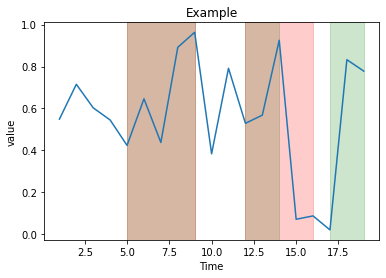

In [26]:
import matplotlib.pyplot as plt

time = range(start, end)
plt.plot(time, signal)

# ground truth
for i, (t1, t2) in enumerate(ground_truth):
    plt.axvspan(t1, t2+1, color="g", alpha=0.2, label="ground_truth")

# detected
for i, (t1, t2) in enumerate(anomalies):
    plt.axvspan(t1, t2+1, color="r", alpha=0.2, label="detected")

    
plt.title("Example")
plt.xlabel("Time")
plt.ylabel("value")
plt.show()

In [27]:
#WEIGHTED APPROACH
from orion.evaluation.contextual import contextual_accuracy, contextual_f1_score

accuracy = contextual_accuracy(ground_truth, anomalies, start=start, end=end)
f1_score = contextual_f1_score(ground_truth, anomalies, start=start, end=end)

print("Accuracy score = {:0.3f}".format(accuracy))
print("F1 score = {:0.3f}".format(f1_score))

Accuracy score = 0.789
F1 score = 0.750


In [28]:
f1_score = contextual_f1_score(ground_truth, anomalies, start=start, end=end, weighted=False)

print("F1 score = {:0.3f}".format(f1_score))

F1 score = 0.800


### Pipeline evaluation end-to-end 

Evaluation suite is integrated into the Orion API, such that you can evaluate the pipeline on a dataset (with its labels) end-to-end. 

`metrics` is list of function names that compares a ground truth labels against detected labels and returns a metric value.  To construct our metrics list we select some of the predefined metrics in Orion, such as:
* Accuracy
* F1 Score
* Precision
* Recall

In [29]:
from orion import Orion
from orion.data import load_signal, load_anomalies
from orion.evaluation.contextual import contextual_accuracy, contextual_f1_score, contextual_precision

metrics = [
    'f1',
    'recall',
    'precision',
]

orion = Orion(
    'tadgan.json'
)

signal = 'ambient_temperature_system_failure'

# load signal
df = load_signal(signal)

# load ground truth anomalies
ground_truth = load_anomalies(signal)

scores = orion.evaluate(df, ground_truth, fit=True, metrics=metrics)

C:\Users\Raunak\.conda\envs\orion\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Raunak\.conda\envs\orion\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Raunak\.conda\envs\orion\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Raunak\.conda\envs\orion\lib\site-packages\keras\engine\training.py:297: UserWarning:

Epoch: 1/35, [Dx loss: [-0.25437984 -1.5921543   0.77711856  0.05606561]] [Dz loss: [-1.7718939  -1.8910224  -0.6315687   0.07506964]] [G loss: [ 1.0022634 -0.7684002  1.1614195  0.0609244]]
Epoch: 2/35, [Dx loss: [-0.8604012  -2.1898744   1.0919362   0.02375368]] [Dz loss: [-2.780351   -1.1027908  -2.6374414   0.09598813]] [G loss: [ 3.3534076  -1.0625521   3.9651384   0.04508215]]
Epoch: 3/35, [Dx loss: [-0.96422327 -1.7450191   0.5567798   0.02240163]] [Dz loss: [-0.6748822   0.12516625 -1.2166247   0.04165759]] [G loss: [ 1.3019778  -0.54944634  1.4006429   0.04507811]]
Epoch: 4/35, [Dx loss: [-0.98667085 -1.9009815   0.71560377  0.01987073]] [Dz loss: [-2.2718303  -0.84826195 -2.3650842   0.09415162]] [G loss: [ 4.18005    -0.7130161   4.4461155   0.04469507]]
Epoch: 5/35, [Dx loss: [-0.8908476  -2.824197    1.711563    0.02217866]] [Dz loss: [ 0.45533878  2.930593   -2.9997087   0.05244557]] [G loss: [ 1.6794838 -1.6847123  3.0273228  0.0336873]]
Epoch: 6/35, [Dx loss: [-0.898743

C:\Users\Raunak\.conda\envs\orion\lib\site-packages\orion\evaluation\common.py:12: RuntimeWarning: overflow encountered in long_scalars
  return first * second < 0


In [30]:
scores

f1           0.871673
recall       0.806805
precision    0.947883
dtype: float64